## Read wind speed and direction from the input file 

In [1]:
# Load a MATLAB file and convert the time to Python datetime objects
import scipy.io
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Load the MATLAB file
mat = scipy.io.loadmat('..\data\Terminos_lagoon_wind_surface_forcing.mat')

# Extract time, U, and V components
matlab_time = mat['Time'].flatten()  # Assuming 'time' is a 1D array
U = mat['XX'].flatten()              # Assuming 'XX' is a 1D array
V = mat['YY'].flatten()              # Assuming 'YY' is a 1D array

# Convert MATLAB time to Python datetime
python_time = [datetime.fromordinal(int(t)) + timedelta(days=t%1) - timedelta(days=366) for t in matlab_time]

# Convert datetime objects to matplotlib date format
python_time_num = [mdates.date2num(t) for t in python_time]

# Convert MATLAB time to Python datetime
python_time = [datetime.fromordinal(int(t)) + timedelta(days=t%1) - timedelta(days=366) for t in matlab_time]

# Create a DataFrame
df = pd.DataFrame({'time': python_time, 'U': U, 'V': V})


## Calculate the resultant wind speed and direction. 

### The wind direction is going towards (oceanographic convention)

In [95]:
# Add the units to the U and V components to calculate wind speed and direction using metpy

from metpy.calc import wind_direction, wind_speed
from metpy.units import pandas_dataframe_to_unit_arrays

# Define units for U and V components
wind_units = {'U': 'm/s', 'V': 'm/s'}

# Convert the DataFrame to unit arrays
unit_arrays = pandas_dataframe_to_unit_arrays(df, column_units=wind_units)

# Calculate wind speed and direction using metpy
unit_arrays['wind_speed_m_s'] = wind_speed(unit_arrays['U'], unit_arrays['V'])
unit_arrays['wind_direction_degree'] = wind_direction(unit_arrays['U'], 
                                               unit_arrays['V'], 
                                               convention= "to" ) # ‘to’ returns the direction the wind is going towards (oceanographic convention)

# Add wind direction and speed back to the DataFrame
df['wind_direction_degree'] = unit_arrays['wind_direction_degree'].magnitude
df['wind_speed_m_s'] = unit_arrays['wind_speed_m_s'].magnitude



## Plot wind direction  and wind speed histogram.

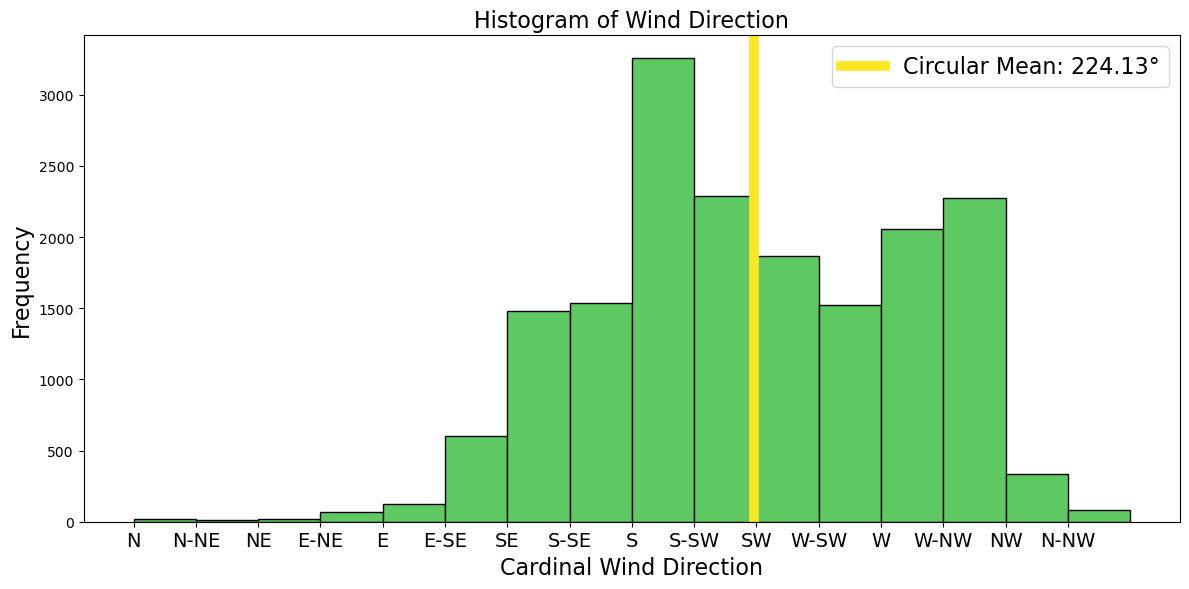

In [96]:
# Plot histogram for wind direction including circular mean
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import circmean

# Calculate circular statistics for wind direction
circular_mean = circmean(unit_arrays['wind_direction_degree'], high=360, low=0)


# Plot histogram for wind direction
plt.figure(figsize=(12, 6))
plt.hist(unit_arrays['wind_direction_degree'], 
         bins=np.arange(0, 361, 22.5), 
         edgecolor='black', color='#5ec962')

# Set xticks and labels
xlabels = (
    "N", "N-NE", "NE", "E-NE", "E", "E-SE", "SE", "S-SE", 
    "S", "S-SW", "SW", "W-SW", "W", "W-NW", "NW", "N-NW"
)

xticks = np.arange(0, 360, 22.5)



plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xlabels,  fontsize=14)
plt.xlabel('Cardinal Wind Direction', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Wind Direction', fontsize=16)

# Plot circular mean
plt.axvline(circular_mean, color='#fde725', 
            linestyle='-', linewidth=7, label=f'Circular Mean: {circular_mean:.2f}°')

# Add legend
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()

# Save the figure in high resolution
plt.savefig('..\output_files\wind_direction_histogram.pdf', dpi=600)

plt.show()

In [ ]:
# Calculate circular statistics for wind direction
from scipy.stats import circmean, circvar, circstd

circular_mean = circmean(unit_arrays['wind_direction_degree'], high=360, low=0)
circular_variance = circvar(unit_arrays['wind_direction_degree'], high=360, low=0)
circular_std = circstd(unit_arrays['wind_direction_degree'], high=360, low=0)

print( f'Circular Mean: {circular_mean:.2f}°')
print( f'Circular Variance: {circular_variance:.2f}°')
print( f'Circular Standard Deviation: {circular_std:.2f}°') 

In [ ]:
# Plot histogram of wind speed
plt.figure(figsize=(10, 6))
plt.hist(df['wind_speed_m_s'], bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Terminos Lagoon Histogram of Wind Speed', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Plot windrose diagram.


In [ ]:
from windrose import WindroseAxes

wind_direction = df['wind_direction_degree']  # My wind direction data
wind_speed = df['wind_speed_m_s']  # My wind speed data

ax = WindroseAxes.from_ax()

ax.bar(
    wind_direction, wind_speed, normed=True,
    edgecolor='white')  
    

ax.set_legend(loc='upper right', fontsize=16)


ax.set_title("Terminos Lagoon Wind Rose", fontsize=16)

plt.show()




_______________________________________________________________________________________________________________________


## Plot wind direction  and wind speed histogram each month.

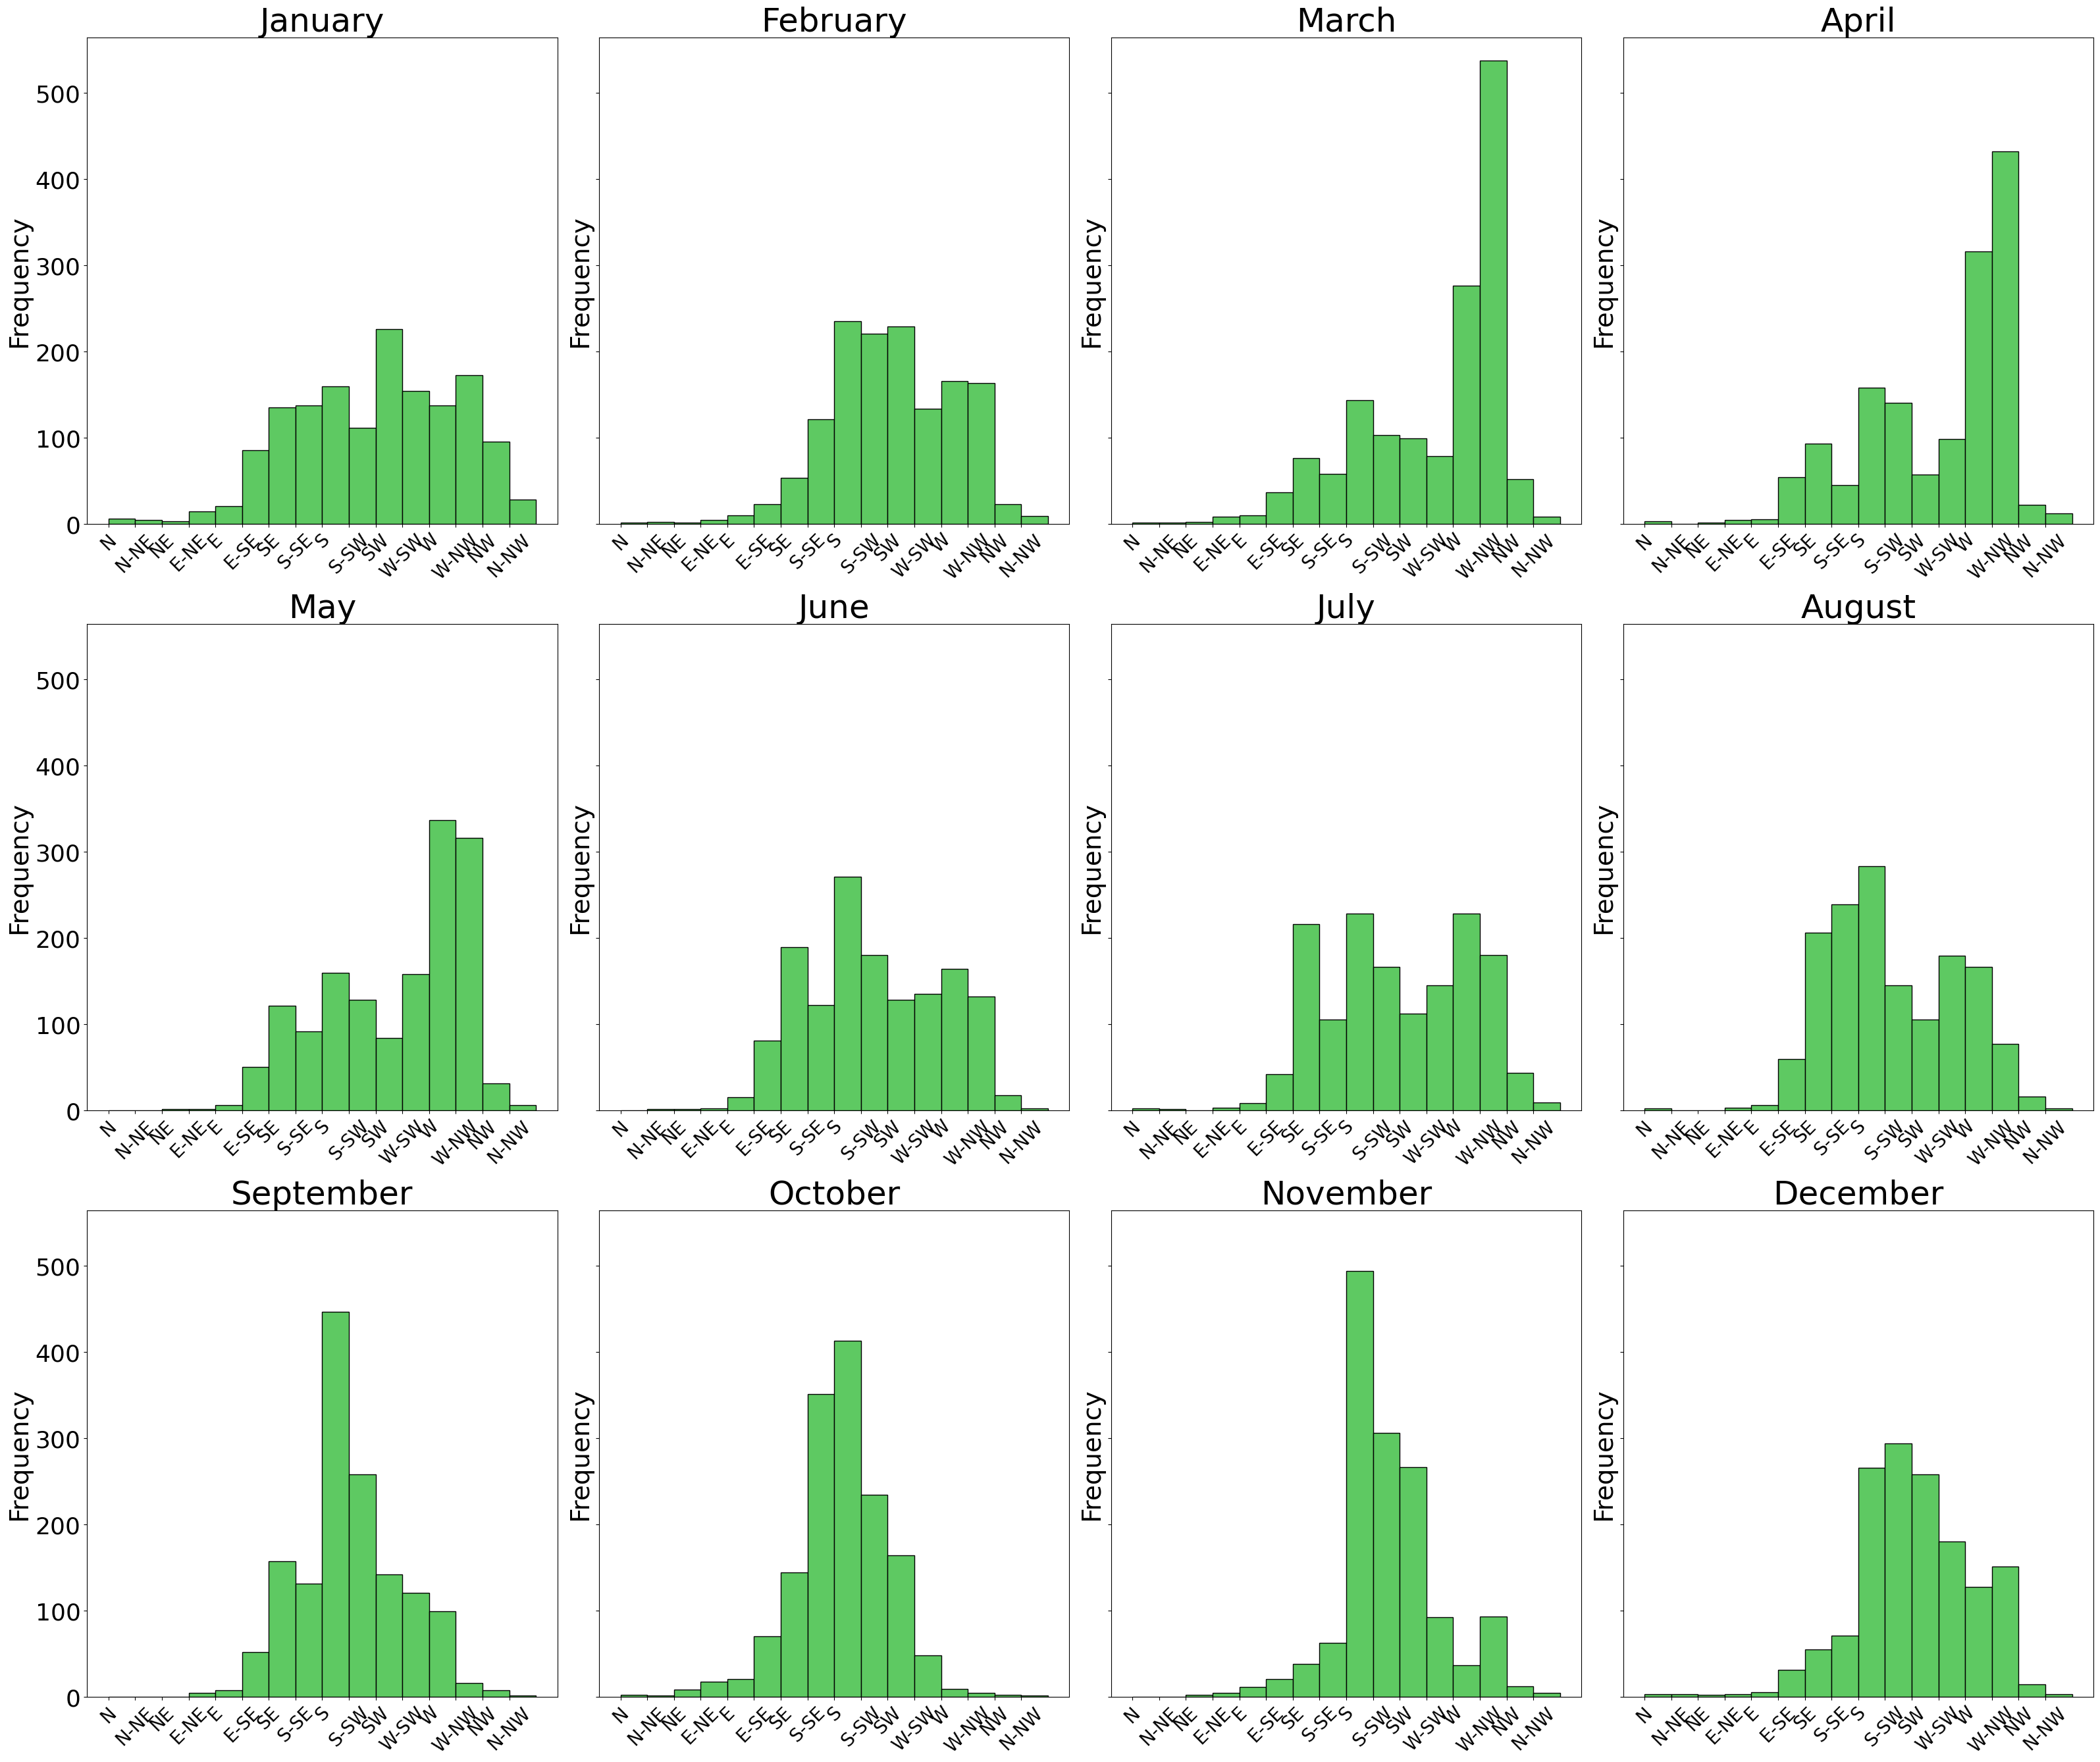

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it contains 'time' and 'wind_direction_degree' columns
# Ensure 'time' is a datetime object
df['time'] = pd.to_datetime(df['time'])

# Extract month from the date
df['Month'] = df['time'].dt.month

# List of month names in English
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Plot histograms for each month
fig, axs = plt.subplots(3, 4, figsize=(32, 28), sharey=True)  # Increased figure size

# Set xticks and labels
xlabels = (
    "N", "N-NE", "NE", "E-NE", "E", "E-SE", "SE", "S-SE", 
    "S", "S-SW", "SW", "W-SW", "W", "W-NW", "NW", "N-NW"
)
xticks = np.arange(0, 360, 22.5)

for month in range(1, 13):
    ax = axs[(month-1)//4, (month-1)%4]
    monthly_data = df[df['Month'] == month]
    ax.hist(monthly_data['wind_direction_degree'], bins=np.arange(0, 361, 22.5), color='#5ec962', edgecolor='black')
    month_name = month_names[month - 1]
    ax.set_title(f'{month_name}', fontsize=36)  # Increased subplot title font size
    ax.set_ylabel('Frequency', fontsize=28)  # Increased y-axis label font size

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=20, rotation=45)  # Increased x-tick label font size
    ax.tick_params(axis='y', labelsize=26)  # Increased y-tick label font size
    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()